<a href="https://colab.research.google.com/github/mnocerino23/MLB-Salary-Regressions/blob/main/Positionplayer_Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Jupyter Notebook, I will build regression models to predict salary (in millions) for MLB position players. I will experiment with different modeling techniques such as multivariate linear, lasso, ridge, and neural network regressions

In [1764]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1765]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

In [1766]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso

In [1767]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [1768]:
#read in position player stats
pp_train = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/MLB/pp_traindata1.csv')
pp_test = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/MLB/pp_testdata.csv')

# Final check for null values:

In [1769]:
#Looks like pp_train has a few null values so we drop them
pp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          280 non-null    int64  
 1   age                 280 non-null    int64  
 2   stints              280 non-null    int64  
 3   G                   279 non-null    float64
 4   tap                 279 non-null    float64
 5   AB                  279 non-null    float64
 6   R                   279 non-null    float64
 7   H                   279 non-null    float64
 8   db                  279 non-null    float64
 9   tr                  279 non-null    float64
 10  HR                  279 non-null    float64
 11  RBI                 279 non-null    float64
 12  SB                  279 non-null    float64
 13  CS                  279 non-null    float64
 14  BB                  279 non-null    float64
 15  SO                  279 non-null    float64
 16  IBB     

In [1770]:
pp_train = pp_train.dropna()

In [1771]:
pp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 0 to 279
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          279 non-null    int64  
 1   age                 279 non-null    int64  
 2   stints              279 non-null    int64  
 3   G                   279 non-null    float64
 4   tap                 279 non-null    float64
 5   AB                  279 non-null    float64
 6   R                   279 non-null    float64
 7   H                   279 non-null    float64
 8   db                  279 non-null    float64
 9   tr                  279 non-null    float64
 10  HR                  279 non-null    float64
 11  RBI                 279 non-null    float64
 12  SB                  279 non-null    float64
 13  CS                  279 non-null    float64
 14  BB                  279 non-null    float64
 15  SO                  279 non-null    float64
 16  IBB     

In [1772]:
#pp_test has no null values so we are good
pp_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          70 non-null     int64  
 1   age                 70 non-null     int64  
 2   stints              70 non-null     int64  
 3   G                   70 non-null     float64
 4   tap                 70 non-null     float64
 5   AB                  70 non-null     float64
 6   R                   70 non-null     float64
 7   H                   70 non-null     float64
 8   db                  70 non-null     float64
 9   tr                  70 non-null     float64
 10  HR                  70 non-null     float64
 11  RBI                 70 non-null     float64
 12  SB                  70 non-null     float64
 13  CS                  70 non-null     float64
 14  BB                  70 non-null     float64
 15  SO                  70 non-null     float64
 16  IBB       

In [1773]:
#drop unnamed index column from both datasets
#also drop the at bats feature since I am now realizing the redunancy here when tap (total plate appearances) contains very similar info
pp_train.drop(columns = ['Unnamed: 0', 'AB'], inplace = True)
pp_test.drop(columns = ['Unnamed: 0', 'AB'], inplace = True)
pp_test.head()

,age,stints,G,tap,R,H,db,tr,HR,RBI,...,C,DH,OF,P,SS,bats_B,bats_L,bats_R,throws_L,throws_R
0,32,1,72.0,251.0,19.0,48.0,12.0,0.0,12.0,41.0,...,1,0,0,0,0,0,0,1,0,1
1,31,1,161.0,680.0,97.0,155.0,25.0,1.0,34.0,97.0,...,0,0,0,0,0,0,0,1,0,1
2,25,1,75.0,248.0,15.0,39.0,9.0,1.0,0.0,15.0,...,0,0,1,0,0,0,0,1,0,1
3,24,1,77.0,288.0,28.0,67.0,11.0,4.0,6.0,26.0,...,0,0,0,0,0,0,0,1,0,1
4,23,1,30.0,80.0,4.0,18.0,6.0,0.0,0.0,4.0,...,0,0,0,0,1,1,0,0,0,1


# Reminding ourselves of the train and test data shapes (we performed an 80-20 split previously then normalized both independently)

In [1774]:
print('Position Players Train:')
print('Train dataset dimensions: ', pp_train.shape, '\n')

print('Position Players Test:')
print('Test dataset dimensions: ', pp_test.shape, '\n')

Position Players Train:
Train dataset dimensions:  (279, 43) 

Position Players Test:
Test dataset dimensions:  (70, 43) 



# Normalize input features using min-max normalization

In [1775]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [1776]:
train_target = pp_train['salary']

train_features = pp_train.drop(columns = ['salary'])
col = train_features.columns
train_features = scaler.fit_transform(train_features)
train_features = pd.DataFrame(data=train_features, columns=col)

In [1777]:
test_target = pp_test['salary']

test_features = pp_test.drop(columns = ['salary'])
test_features = scaler.fit_transform(test_features)
test_features = pd.DataFrame(data=test_features, columns=col)

# Feature Selection

Vary the number of features we select to find optimal amount. I found that k = 12 features produces the best model with MAE of 3.49 million

In [1778]:
#top_features_ordered = []

In [1779]:
#best_features = SelectKBest(f_regression, k=12)
#k_best_data = best_features.fit_transform(train_features, train_target)
#mask = best_features.get_support()
#new_features = train_features.columns[mask]
#for item in new_features:
  #if item not in top_features_ordered:
   # top_features_ordered.append(item)

In [1780]:
#count = 1
#for item in top_features_ordered:
  #print(count, '. ', item)
  #count += 1

In [1781]:
train_selected_X = train_features[['age', 'G', 'RBI', 'H', 'GIDP', 'PRO', 'Rookie contract', 'ops']]
train_y = train_target

test_selected_X = test_features[['age', 'G', 'RBI', 'H', 'GIDP', 'PRO', 'Rookie contract', 'ops']]
test_y = test_target

In [1782]:
print('Train Features:')
print('train_selected_X dimensions: ', train_selected_X.shape)
print('train_y dimensions:', train_y.shape, '\n')

print('Test Features:')
print('test_data_X dimensions: ', test_selected_X.shape)
print('test_data_y dimensions:', test_y.shape, '\n')

Train Features:
train_selected_X dimensions:  (279, 8)
train_y dimensions: (279,) 

Test Features:
test_data_X dimensions:  (70, 8)
test_data_y dimensions: (70,) 



# Multivariate Linear Regression

In [1783]:
multivariate_regression = linear_model.LinearRegression()
multivariate_regression.fit(train_selected_X, train_y)

LinearRegression()

# Beta values (coefficients) and intercept for our multivariate linear regression:

In [1784]:
multivariate_regression.coef_

array([18.52392221, -9.3448351 , -2.64652833, -3.67020106,  6.47866356,
       22.15176025,  0.96789912, -5.06003056])

In [1785]:
multivariate_regression.intercept_

-3.433813074304056

In [1786]:
y_pred = multivariate_regression.predict(test_selected_X)

In [1787]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_pred), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_pred), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_pred)))

Mean Squared Error:  20.957202516377947 

Mean Absolute Error:  3.3962689166115063 

Root Mean Squared Error:  4.577903725110211


# Ridge Regression

In [1788]:
ridge_regression = Ridge(alpha = 3.6)
ridge_regression.fit(train_selected_X, train_y)

Ridge(alpha=3.6)

In [1789]:
ridge_regression.coef_

array([11.07806031, -1.65674287,  1.83675343,  1.95171635,  4.75308528,
        3.71003721, -1.14919075, -0.14232078])

In [1790]:
ridge_regression.intercept_

-3.467443225653951

In [1791]:
y_predicted = ridge_regression.predict(test_selected_X)

In [1792]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_predicted), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_predicted), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_predicted)))

Mean Squared Error:  21.64512449510722 

Mean Absolute Error:  3.3521156194724258 

Root Mean Squared Error:  4.65243210537319


# Lasso Regression

In [1793]:
lasso_regression = Lasso(alpha = 2.0)
lasso_regression.fit(train_selected_X, train_y)

Lasso(alpha=2.0)

In [1794]:
lasso_regression.coef_

array([ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.])

In [1795]:
lasso_regression.intercept_

4.435841802867383

In [1796]:
y_predicted_lasso = lasso_regression.predict(test_selected_X)

In [1797]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_predicted_lasso), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_predicted_lasso), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_predicted_lasso)))

Mean Squared Error:  41.093660018288 

Mean Absolute Error:  4.860481701228878 

Root Mean Squared Error:  6.41043368410344


# Regression with Deep Learning

In [1798]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

In [1799]:
tf.random.set_seed(5)

network1 = tf.keras.models.Sequential()
network1.add(tf.keras.Input(shape=(42,)))
network1.add(tf.keras.layers.Dense(15, activation='relu'))
network1.add(tf.keras.layers.Dense(15, activation='tanh'))
network1.add(tf.keras.layers.Dense(15, activation='relu'))
network1.add(tf.keras.layers.Dense(1))

network1.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history1 = network1.fit(train_features, train_target, epochs=75,validation_data=(test_features,test_target))

Epoch 1/75
9/9 [==============================] - 2s 40ms/step - loss: 4.2449 - mean_absolute_error: 4.2449 - val_loss: 4.2371 - val_mean_absolute_error: 4.2371
Epoch 2/75
9/9 [==============================] - 0s 14ms/step - loss: 3.9635 - mean_absolute_error: 3.9635 - val_loss: 4.1108 - val_mean_absolute_error: 4.1108
Epoch 3/75
9/9 [==============================] - 0s 25ms/step - loss: 3.8790 - mean_absolute_error: 3.8790 - val_loss: 4.0657 - val_mean_absolute_error: 4.0657
Epoch 4/75
9/9 [==============================] - 0s 26ms/step - loss: 3.8497 - mean_absolute_error: 3.8497 - val_loss: 4.0385 - val_mean_absolute_error: 4.0385
Epoch 5/75
9/9 [==============================] - 0s 24ms/step - loss: 3.8255 - mean_absolute_error: 3.8255 - val_loss: 4.0124 - val_mean_absolute_error: 4.0124
Epoch 6/75
9/9 [==============================] - 0s 21ms/step - loss: 3.7976 - mean_absolute_error: 3.7976 - val_loss: 3.9838 - val_mean_absolute_error: 3.9838
Epoch 7/75
9/9 [==================

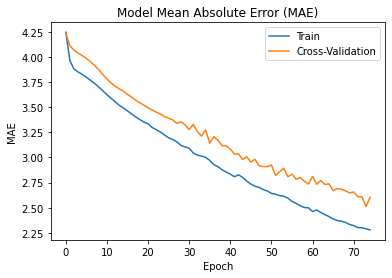

In [1800]:
from matplotlib import pyplot as plt
plt.plot(history1.history['mean_absolute_error'])
plt.plot(history1.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

In [1801]:
tf.random.set_seed(5)

network2 = tf.keras.models.Sequential()
network2.add(tf.keras.Input(shape=(42,)))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(1))

network2.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history2 = network2.fit(train_features, train_target, epochs=80,validation_data=(test_features,test_target))

Epoch 1/80
9/9 [==============================] - 1s 25ms/step - loss: 4.3053 - mean_absolute_error: 4.3053 - val_loss: 4.3583 - val_mean_absolute_error: 4.3583
Epoch 2/80
9/9 [==============================] - 0s 6ms/step - loss: 4.0744 - mean_absolute_error: 4.0744 - val_loss: 4.1847 - val_mean_absolute_error: 4.1847
Epoch 3/80
9/9 [==============================] - 0s 7ms/step - loss: 3.9430 - mean_absolute_error: 3.9430 - val_loss: 4.1016 - val_mean_absolute_error: 4.1016
Epoch 4/80
9/9 [==============================] - 0s 7ms/step - loss: 3.8760 - mean_absolute_error: 3.8760 - val_loss: 4.0479 - val_mean_absolute_error: 4.0479
Epoch 5/80
9/9 [==============================] - 0s 5ms/step - loss: 3.8488 - mean_absolute_error: 3.8488 - val_loss: 4.0063 - val_mean_absolute_error: 4.0063
Epoch 6/80
9/9 [==============================] - 0s 6ms/step - loss: 3.8227 - mean_absolute_error: 3.8227 - val_loss: 3.9776 - val_mean_absolute_error: 3.9776
Epoch 7/80
9/9 [=======================

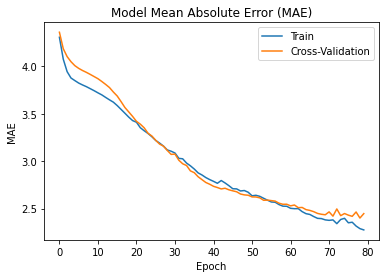

In [1802]:
from matplotlib import pyplot as plt
plt.plot(history2.history['mean_absolute_error'])
plt.plot(history2.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()